# this uses spherical integration of isotropic gaussian

taken from 2024Spring08_SphericalGaussianDiffusion in RA folder

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/PartialNephrectomy_Python"))
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/RenalAllograft_Python"))

from ML_UsefulFunctions import *
from KidneyROIAnalyses import *
from RenalAllograftFunctions import *
from DataLeakageCorrections import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import f_oneway

from collections import Counter
from sklearn.feature_selection import SequentialFeatureSelector

pl.rcParams["font.family"] = "Times New Roman"


import warnings
warnings.simplefilter("ignore")

In [2]:
#with a known D, t, and a, calculate integral. 

#this is the gaussian integral with sigma = sqrt(4Dt)
def integrand(x,D,t):
    sigma = np.sqrt(2*D*t)
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp(-np.power(x/sigma, 2.)/2) 

def integrand_3D(r,phi,theta,sigma):
    return r**2 * np.sin(theta) * (1./(np.power(sigma*np.sqrt(2*np.pi),3))) * np.exp(-np.power(r/sigma, 2.)/2) 
    
# this integrates a 3D gaussian integral with radius a
def integrate_3Dsphere(a,D,t):
    sigma = np.sqrt(2*D*t)
    integral = tplquad(integrand_3D, 
                       0, np.pi, 0,2*np.pi, 0, a, args=(sigma,))
    return integral[0]

def find_nearest_time(t, y, value):
    array = np.asarray(y)
    idx = (np.abs(array - value)).argmin()
    return t[idx]

def RiemannSum(x,y):
    n = len(x) #number of sums
    summed = 0
    for i in range(1,n):
        Sum_y = (y[i-1] + y[i])/2
        Deltax = x[i] - x[i-1]
        summed = summed + (Sum_y*Deltax)
    return summed

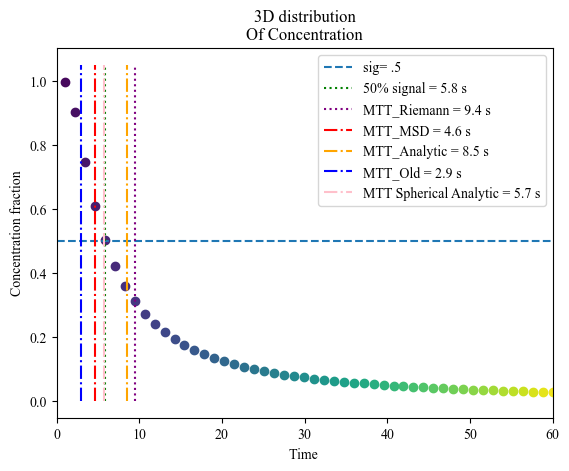

Calib coeff analytic = 62327.4
Calib coeff old = 178603.2
Calib coeff MSD = 113760.0
Calib coeff 50% = 92578.1


In [3]:
# plot of concentration within a voxel of size 1 
# this shows the fraction of signal remaining in the voxel
conc= []
time = np.linspace(1,60,50)
for t in time:
    with sns.color_palette('viridis',50): 
        a = .5
        D = .009
        conc_t = integrate_3Dsphere(a,D,t)
        conc = np.append(conc,conc_t)
        pl.scatter(t,conc_t)
        
pl.xlim(0,60)
#pl.ylim(0,1.05)
pl.ylabel('Concentration fraction')
pl.xlabel('Time ')
#pl.legend(bbox_to_anchor=(1.3,1.03))
pl.title('3D distribution\nOf Concentration')

#find 50% signal drop
HalfLife = find_nearest_time(time, conc, .5)
pl.hlines(.5,0,200,linestyle = '--',label = 'sig= .5')
pl.vlines(HalfLife,0,1.05,linestyle = 'dotted',color = 'green',label = f'50% signal = {HalfLife:.1f} s')

# find MTT
MTT = RiemannSum(time,conc)
pl.vlines(MTT,0,1.05,linestyle = 'dotted',color = 'purple',label = f'MTT_Riemann = {MTT:.1f} s')

# show MTT using MSD = a^2, i.e. where if MSD = (.5)^2 = 6D*MTT, or MTT  = .5^2/6*D
MSD_MTT = np.power(.5,2)/(6*D)
pl.vlines(MSD_MTT,0,1.05,linestyle = 'dashdot',color = 'red',label = f'MTT_MSD = {MSD_MTT:.1f} s')

# show MTT using old version of 50%, i.e. where MTT = (.5)*79176^2/2D
# see 12/12/22
MTT_Analytic_50 = np.power(.39,2)/(2*D)
pl.vlines(MTT_Analytic_50,0,1.05,linestyle = 'dashdot',color = 'orange',label = f'MTT_Analytic = {MTT_Analytic_50:.1f} s')

#old version
MTT_old = np.power(.5,2)/(6*D*1.57)
pl.vlines(MTT_old,0,1.05,linestyle = 'dashdot',color = 'blue',label = f'MTT_Old = {MTT_old:.1f} s')

# New spherical analytic attempt
MTT_Spherical_Analytic = np.power(.32,2)/(2*D)
pl.vlines(MTT_Spherical_Analytic,0,1.05,linestyle = 'dashdot',color = 'pink',label = f'MTT Spherical Analytic = {MTT_Spherical_Analytic:.1f} s')

pl.legend()
pl.show()


## Wait so MSD should be best, and have the highest coefficient??? Im so confused. 
Calib_analytic = 60*100*.79/(MTT_Analytic_50*D)
Calib_old = 60*100*.79/(MTT_old*D)
Calib_MSD = 60*100*.79/(MSD_MTT*D)
Calib_50 = 60*100*.79/(HalfLife*D)
Calib_Spherical = 60*100*.79/(MTT_Spherical_Analytic*D)

print(f'Calib coeff analytic = {Calib_analytic:.1f}')
print(f'Calib coeff old = {Calib_old:.1f}')
print(f'Calib coeff MSD = {Calib_MSD:.1f}')
print(f'Calib coeff 50% = {Calib_Spherical:.1f}')




In [4]:
# for prettier plot:
conc1= []
time1 = np.linspace(1,60,25)
for t in time1:
    with sns.color_palette('viridis',25): 
        a = .5
        D = .009
        conc_t = integrate_3Dsphere(a,D,t)
        conc1 = np.append(conc1,conc_t)
        #pl.scatter(t,conc_t)
        

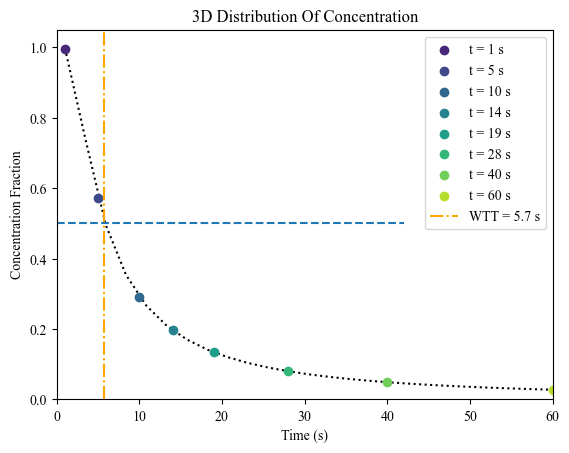

In [5]:
# plot of concentration within a voxel of size 1 
# this shows the fraction of signal remaining in the voxel
conc= []
times_wanted = [1,5,10,14,19,28,40,60]
for t in times_wanted:
    with sns.color_palette('viridis',8): 
        a = .5
        D = .009
        conc_t = integrate_3Dsphere(a,D,t)
        conc = np.append(conc,conc_t)
        pl.scatter(t,conc_t,label = f't = {t:.0f} s')

pl.plot(time1,conc1,linestyle = 'dotted',color = 'black',zorder = 0)      
pl.xlim(0,60)
pl.ylim(0,1.05)
pl.ylabel('Concentration Fraction')
pl.xlabel('Time (s)')
#pl.plot(times_wanted,conc,linestyle = 'dotted',color = 'black',zorder = 0)
#pl.legend(bbox_to_anchor=(1.3,1.03))
pl.title('3D Distribution Of Concentration')

# New spherical analytic attempt
MTT_Spherical_Analytic = np.power(.32,2)/(2*D)
pl.vlines(MTT_Spherical_Analytic,0,1.05,linestyle = 'dashdot',color = 'orange',label = f'WTT = {MTT_Spherical_Analytic:.1f} s')

pl.hlines(.5,0,42,linestyle = '--')

pl.legend()
#pl.savefig('/Users/neuroimaging/Desktop/Dissertation/Figures/3D_Concentration.png',dpi = 150)

pl.show()





# attempt at showing graphically

In [6]:
def get_sphere_points(r,n):
    x = np.random.normal(0,r,n)
    y = np.random.normal(0,r,n)
    z = np.random.normal(0,r,n)
    xp,yp,zp = [],[],[]
    for k in range(n): 
        if x[k]**2 + y[k]**2 + z[k]**2 <= r**2:
            xp.append(x[k])
            yp.append(y[k])
            zp.append(z[k])
    return xp,yp,zp
            
        
    


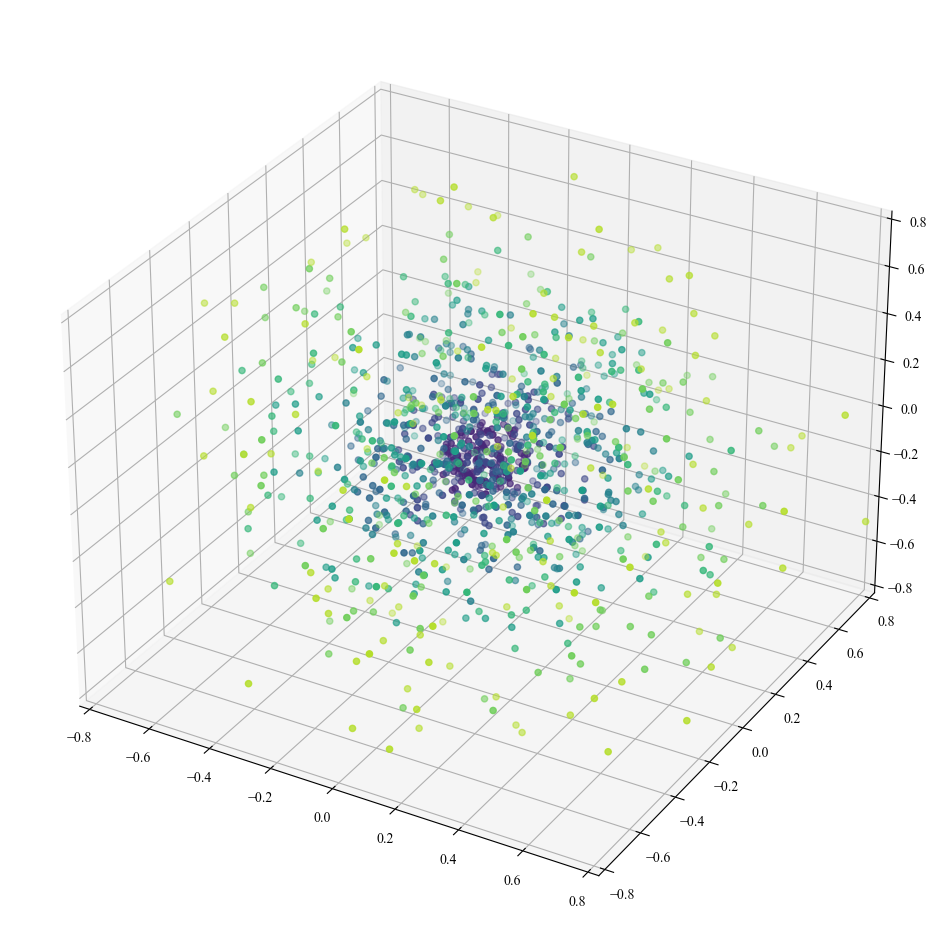

In [7]:
from mpl_toolkits import mplot3d
fig = pl.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
times_wanted = [1,5,10,14,19,28,40,60]
D = .01

#cmap = ListedColormap(sns.color_palette('viridis',50).as_hex())
for i in range(8):
    t = times_wanted[i]
    sigma = np.sqrt(2*D*t)
    xp,yp,zp = get_sphere_points(sigma,700)
    ax.scatter(xp,yp,zp, c = sns.color_palette('viridis',8).as_hex()[i])


#pl.title('3D Gaussian Distribution Over Time')
ax.set_xlim(-.8,.8)
ax.set_ylim(-.8,.8)
ax.set_zlim(-.8,.8)

# remove axis and grid lines
#ax.grid(False)
#pl.axis('off')
#pl.savefig('/Users/neuroimaging/Desktop/Dissertation/Figures/3D_GaussianDist.png',dpi = 100)
pl.show()

# now with multicompartment gaussian

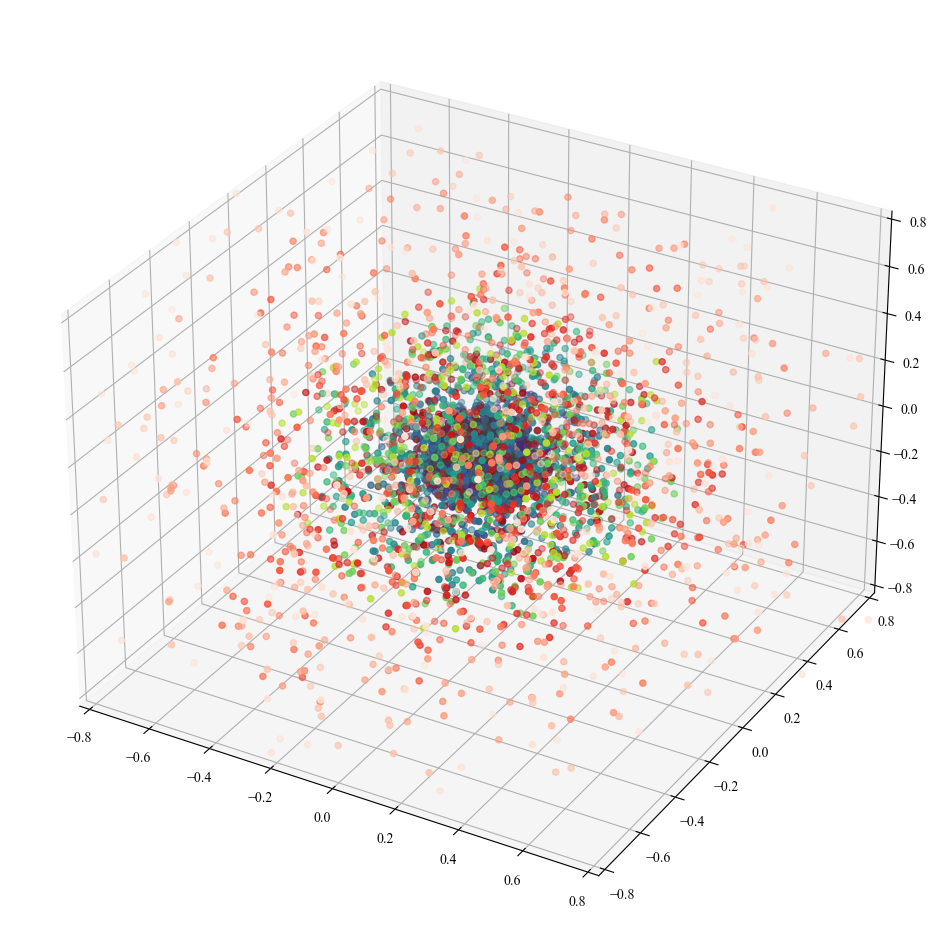

In [8]:
from mpl_toolkits import mplot3d
fig = pl.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
times_wanted = [1,2,3,5,6,7,8,9,10,14,16,19,24,28,40,60,80, 90, 100]
Dtissue = .002 #tissue
Dtubule = .0200 #tubules
Dvasc = .0800 #vascular

ftissue = .6
ftubule = .3
fvasc= .1
#cmap = ListedColormap(sns.color_palette('viridis',50).as_hex())
for i in range(8):
    t = times_wanted[i]

    sigma = np.sqrt(2*Dvasc*t)
    xp,yp,zp = get_sphere_points(sigma,int(1000))
    ax.scatter(xp,yp,zp, c = sns.color_palette('Reds_r',8).as_hex()[i])
    
 
    sigma = np.sqrt(2*Dtubule*t)
    xp,yp,zp = get_sphere_points(sigma,int(1000))
    ax.scatter(xp,yp,zp, c = sns.color_palette('viridis',8).as_hex()[i])
    
    
    sigma = np.sqrt(2*Dtissue*t)
    xp,yp,zp = get_sphere_points(sigma,int(1000))
    ax.scatter(xp,yp,zp, c = sns.color_palette('Greys_d',8).as_hex()[i])


#pl.title('3D Gaussian Distribution Over Time')
ax.set_xlim(-.8,.8)
ax.set_ylim(-.8,.8)
ax.set_zlim(-.8,.8)

# remove axis and grid lines
#ax.grid(False)
#pl.axis('off')
#pl.savefig('/Users/neuroimaging/Desktop/Dissertation/Figures/3D_GaussianDist.png',dpi = 100)
pl.show()

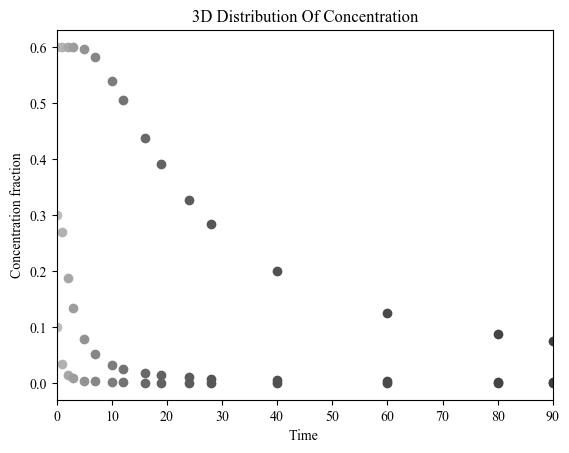

In [9]:
# plot of concentration within a voxel of size 1 
# this shows the fraction of signal remaining in the voxel
conc= []
conc= []
conc= []
#time = np.linspace(1,60,25)
time = [0.1,1,2,3,5,6,7,8,9,10,14,16,19,24,28,40,60,80, 90, 100]
time = [.1,1,2,3,5,7,10, 12,16,19,24,28,40,60,80, 90, 100]

for t in time:
    with sns.color_palette('Greys_d',len(time)): 
        r = .5
        conc_t = integrate_3Dsphere(r,Dtissue,t)
        conc = np.append(conc,conc_t)
        pl.scatter(t,conc_t*ftissue)
        
for t in time:
    with sns.color_palette('viridis',len(time)): 
        r = .5
        conc_t = integrate_3Dsphere(r,Dtubule,t)
        conc = np.append(conc,conc_t)
        pl.scatter(t,conc_t*ftubule)
        
for t in time:
    with sns.color_palette('Reds_r',len(time)): 
        r = .5
        conc_t = integrate_3Dsphere(r,Dvasc,t)
        conc = np.append(conc,conc_t)
        pl.scatter(t,conc_t*fvasc)
        
pl.xlim(0,90)
#pl.ylim(0,1.05)
pl.ylabel('Concentration fraction')
pl.xlabel('Time ')
#pl.legend(bbox_to_anchor=(1.3,1.03))
pl.title('3D Distribution Of Concentration')
pl.show()

In [10]:
# plot of concentration within a voxel of size 1 
# this shows the fraction of signal remaining in the voxel
conc= []
conc_tisss= []
conc_tubs= []
conc_vascs= []
#time = np.linspace(1,60,25)
time = [.1,1,2,3,5,7,10, 12,16,19,24,28,40,60,80, 90, 100]

for t in time: 
    r = .5
    conc_tiss = integrate_3Dsphere(r,Dtissue,t)
    conc_tub = integrate_3Dsphere(r,Dtubule,t)
    conc_vasc = integrate_3Dsphere(r,Dvasc,t)
    conc = np.append(conc,conc_tiss*ftissue+conc_tub*ftubule + conc_vasc*fvasc)
    #pl.scatter(t,conc_tiss*ftissue+conc_tub*ftubule + conc_vasc*fvasc)
    conc_tisss = np.append(conc_tisss, conc_tiss)
    conc_tubs = np.append(conc_tubs,conc_tub)
    conc_vascs = np.append(conc_vascs, conc_vasc)
    


In [51]:
matplotlib.rcParams.update({'font.size': 16})
pl.rcParams["font.family"] = "serif"
pl.rcParams["mathtext.fontset"] = "dejavuserif"

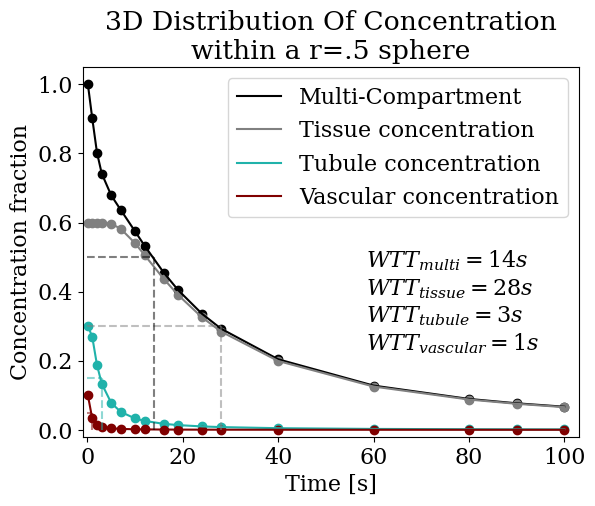

In [69]:


pl.scatter(time,conc,color = 'black')
pl.plot(time,conc, color = 'black', label = 'Multi-Compartment')

pl.scatter(time,conc_tisss*ftissue,color = 'grey')
pl.plot(time,conc_tisss*ftissue, color = 'grey', label = 'Tissue concentration')

pl.scatter(time,conc_tubs*ftubule,color = 'lightseagreen')
pl.plot(time,conc_tubs*ftubule, color = 'lightseagreen', label = 'Tubule concentration')

pl.scatter(time,conc_vascs*fvasc,color = 'maroon')
pl.plot(time,conc_vascs*fvasc, color = 'maroon', label= 'Vascular concentration')
pl.xlim(-1,103)
pl.ylim(-0.02,1.05)
pl.ylabel('Concentration fraction')
pl.xlabel('Time [s]')
#pl.legend(bbox_to_anchor=(1.3,1.03))
pl.title('3D Distribution Of Concentration\nwithin a r=.5 sphere')
pl.hlines(.3, 0,28,color = 'grey',alpha=0.5,linestyle='--')#, alpha=.5)
pl.hlines(.15, 0,3,color = 'lightseagreen',alpha=0.5,linestyle='--')#,alpha=.5)
pl.hlines(.05,0,1,color = 'maroon',alpha=0.5,linestyle='--')#,alpha=.5)
pl.hlines(.5,0,14,color = 'black',alpha=0.5,linestyle='--')

pl.vlines(1,0,.05,color='maroon',alpha=0.5,linestyle='--')
pl.vlines(14,0,.5,color='black',alpha=0.5,linestyle='--')
pl.vlines(3,0,.15,color='lightseagreen',alpha=0.5,linestyle='--')
pl.vlines(28,0,.3,color='grey',alpha=0.5,linestyle='--')

#pl.scatter(1,0.05,s=100,facecolors='none', edgecolors='maroon')
#pl.scatter(14,0.5,s=100,facecolors='none', edgecolors='black')
#pl.scatter(3,0.15,s=100,facecolors='none', edgecolors='lightseagreen')
#pl.scatter(28,0.3,s=100,facecolors='none', edgecolors='grey')
s = '$WTT_{multi}=14s $\n$WTT_{tissue} = 28s$ \n$WTT_{tubule}=3s$ \n$WTT_{vascular}=1s$'
pl.text(58.5,.23,s)

pl.legend()
pl.show()

# just the exponentials

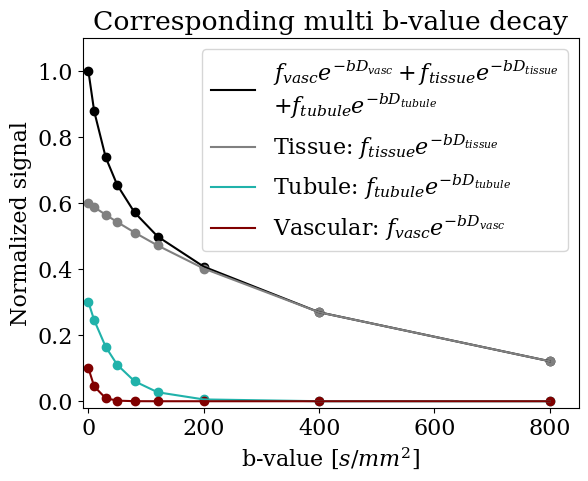

In [55]:
b = np.array([0, 10, 30, 50, 80, 120, 200, 400, 800])

pl.scatter(b, fvasc*np.exp(-b*Dvasc)+ftubule*np.exp(-b*Dtubule)+ftissue*np.exp(-b*Dtissue), color = 'black')
pl.plot(b, fvasc*np.exp(-b*Dvasc)+ftubule*np.exp(-b*Dtubule)+ftissue*np.exp(-b*Dtissue), color = 'black', label = '$f_{vasc}e^{-bD_{vasc}} + f_{tissue}e^{-bD_{tissue}}$\n$+ f_{tubule}e^{-bD_{tubule}}$')

pl.scatter(b, ftissue*np.exp(-b*Dtissue),color = 'grey')
pl.plot(b, ftissue*np.exp(-b*Dtissue), label = 'Tissue: $f_{tissue}e^{-bD_{tissue}}$', color = 'grey')

pl.scatter(b, ftubule*np.exp(-b*Dtubule),color = 'lightseagreen')
pl.plot(b, ftubule*np.exp(-b*Dtubule), label = 'Tubule: $f_{tubule}e^{-bD_{tubule}}$', color = 'lightseagreen')

pl.scatter(b, fvasc*np.exp(-b*Dvasc),color = 'maroon')
pl.plot(b, fvasc*np.exp(-b*Dvasc), label = 'Vascular: $f_{vasc}e^{-bD_{vasc}}$', color = 'maroon')

pl.legend()
pl.title('Corresponding multi b-value decay')
pl.xlabel('b-value [$s/mm^2$]')
pl.ylabel('Normalized signal')
pl.xlim(-10,850)
pl.ylim(-0.02,1.1)
pl.show()

# showing spectral analysis

In [56]:
signal=fvasc*np.exp(-b*Dvasc)+ftubule*np.exp(-b*Dtubule)+ftissue*np.exp(-b*Dtissue)

In [57]:
fileloc = '/Users/miraliu/Desktop/PostDocCode/Multiexp_Simulations_python/RA_Spectra.xlsx'
Spectra_Data = pd.read_excel(fileloc,sheet_name = 'SpectralPlots') 

def plotmodel(bvals, modelvals):
    return modelvals[0]*np.exp(-bvals*modelvals[4]/1000) + modelvals[1]*np.exp(-bvals*modelvals[5]/1000) + modelvals[2]*np.exp(-bvals*modelvals[6]/1000) + modelvals[3]*np.exp(-bvals*modelvals[7]/1000)
    
    

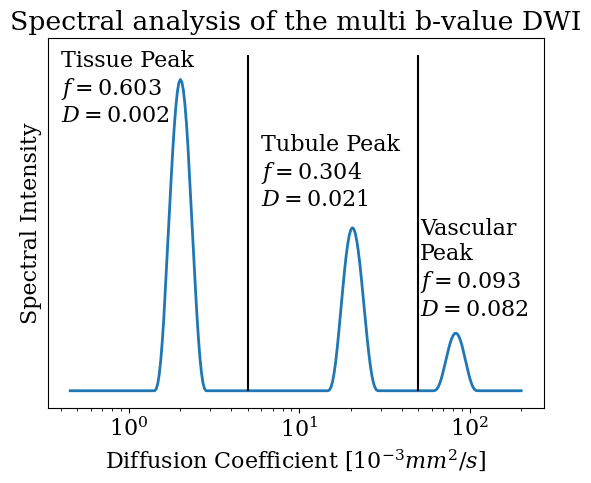

In [59]:
b =[0, 10, 30, 50, 80, 120, 200, 400, 800]

ADCBasisSteps = 300
ADCBasis = np.logspace(np.log10(5), np.log10(2200), ADCBasisSteps)
x = 1/ADCBasis


df = Spectra_Data
pl.plot(x*1000, df.iloc[2,10:], linewidth = 2)
pl.xscale('log', base=10)
pl.vlines(5, 0, .04,color = 'black')
pl.vlines(50, 0, .04, color = 'black')
pl.xlabel('Diffusion Coefficient [$10^{-3} mm^2/s$]')
pl.ylabel('Spectral Intensity')

#pl.text()
pl.yticks([])

pl.text(.4,0.032,'Tissue Peak\n$f=0.603$\n$D=0.002$')
pl.text(6,0.022,'Tubule Peak\n$f=0.304$\n$D=0.021$')
pl.text(51,0.009,'Vascular\nPeak\n$f=0.093$\n$D=0.082$')
pl.title('Spectral analysis of the multi b-value DWI')
pl.show()


In [17]:
df.iloc[0,300:309]

Unnamed: 300   0.000
Unnamed: 301   0.000
Unnamed: 302   0.000
Unnamed: 303   0.000
Unnamed: 304   0.000
Unnamed: 305   0.000
Unnamed: 306   0.000
Unnamed: 307   0.000
Unnamed: 308   0.000
Name: 0, dtype: object